## Overview

Your assignment is to create a colorized river basin map for your country using [HydroRIVERS](https://www.hydrosheds.org/products/hydrorivers) data.

This notebook contains code to download, extract and pre-process the data. Your task is to plot the rivers using Matplotlib and achieve a unique style shown below.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/assignment.png' width=800/>

## Setup and Data Download

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install geopandas mapclassify pysal pyogrio

In [ ]:
import os
import geopandas as gpd
import requests
import zipfile
import matplotlib.pyplot as plt

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Select a continent code. Visit [HydroRIVERS](https://www.hydrosheds.org/products/hydrorivers) and replace the value with the continent that your country is in. For example, here we want to create a map of rivers of India, so the continent code used is `as` (Asia). You can right-click the download link for any continent and see the continent code in the URL.

In [ ]:
continent = 'as'

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
      with requests.get(url, stream=True, allow_redirects=True) as r:
          with open(filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  f.write(chunk)
      print('Downloaded', filename)

rivers_file = f'HydroRIVERS_v10_{continent}_shp.zip'
countries_file = 'ne_10m_admin_0_countries_ind.zip'

hydrorivers_url = 'https://data.hydrosheds.org/file/HydroRIVERS/'
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/raw/main/data/naturalearth/'
download(hydrorivers_url + rivers_file)
download(data_url + countries_file)


Unzip and extract the shapefiles.

In [ ]:
rivers_filepath = os.path.join(data_folder, rivers_file)
countries_filepath = os.path.join(data_folder, countries_file)

for f in [rivers_filepath, countries_filepath]:
  with zipfile.ZipFile(f) as zf:
    zf.extractall(data_folder)

river_shapefilepath = os.path.join(
    data_folder, 'HydroRIVERS_v10_as_shp',
    f'HydroRIVERS_v10_{continent}.shp')
countries_filepath = os.path.join(
    data_folder, os.path.splitext(countries_file)[0] + '.shp')

## Data Pre-Processing

We select a country and extract the country geometry from the Natural Earth countries shapefile. Replace the `country` variable with the name of your chosen country.

*Hint: You can print a list of values from the `SOVEREIGNT` column of `country_gdf` GeoDataFrame using `country_gdf.SOVEREIGNT.values` to know the value for your country.*

In [ ]:
country = 'India'
country_gdf = gpd.read_file(countries_filepath)
filtered_gdf = country_gdf[country_gdf['SOVEREIGNT'] == country]
filtered_gdf

 We read the river network and select river lines where the the `UPLAND_SKM` value is greater than 100 sq. km. This removes smaller streams from the dataset.

In [ ]:
river_gdf = gpd.read_file(river_shapefilepath, bbox=filtered_gdf, engine='pyogrio')
river_gdf_filtered = river_gdf[river_gdf['UPLAND_SKM'] >= 100].copy()
river_gdf_filtered

Clip the rivers to the country boundary. This step can take a few minutes depending on the size of the country.

In [ ]:
rivers_gdf_clipped = river_gdf_filtered.clip(filtered_gdf)

We want to style the rivers so that the width of the line is proportional to the value in the `UPLAND_SKM` attribute. We add a new column `width` to the GeoDataFrame by scaling the input values to a range of target widths.

*Tip: These values will play an important role in your final visualization. Adjust these to suit the range of values for your country.*

In [ ]:
original_min = 100
original_max = 10000
target_min = 0.2
target_max = 0.9
scaled = (rivers_gdf_clipped['UPLAND_SKM'] - original_min) / (original_max - original_min)
rivers_gdf_clipped['width'] = scaled.clip(0, 1) * (target_max - target_min) + target_min
rivers_gdf_clipped

Visualize the river network.

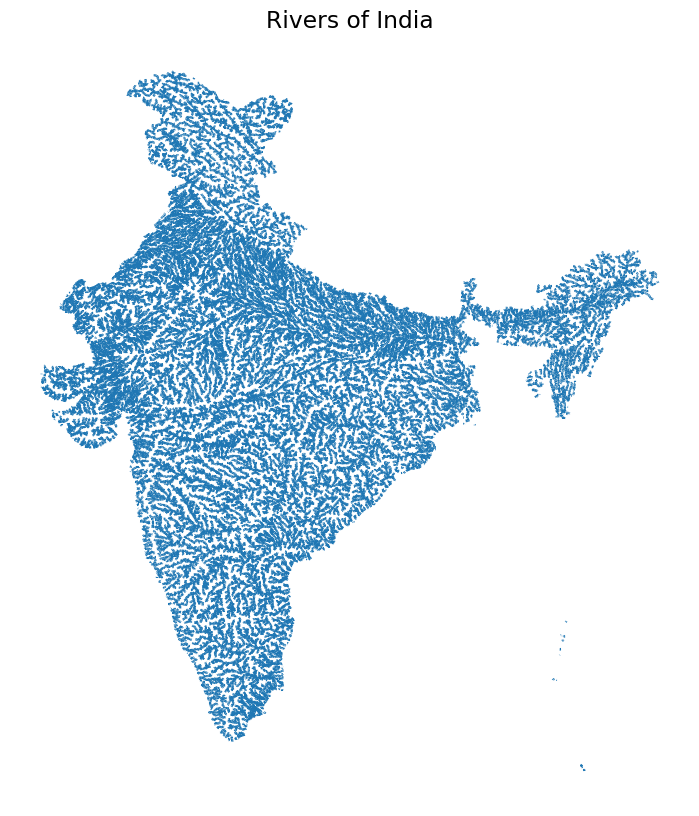

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
title = f'Rivers of {country}'
rivers_gdf_clipped.plot(ax=ax)
ax.set_title(title)
ax.set_axis_off()
plt.show()

Your task is to render the river network by applying the following changes. Refer to the [`geopandas.GeoDataFrame.plot()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) documentation for parameter values and options.

*   Assign a color to each river segment based on the value of `MAIN_RIV` column. *Hint: set `categorical=True`*.
*  Assign width to each item based on the value in the `width` column.
* Set the map background to black.
* Set the title to white and change the font to be larger.